# Table of Contents
 1. Introduction to Problem Statment
 2. Understanding Folder Structure
 3. Understanding Data Set
 4. Data Preparation
 5. Method1: Pixel values as features
 6. Model1: Model building using Pixel Features
 7. Method 2: HOG Features
 8. Model2: Model building using HOG Features

# 1. Introduction to Problem Statement

Malaria is one of the deadliest diseases. It is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.


However, Malaria diagnosis involves close examination of the blood smear at 100x magnification. This is followed by a manual counting process wherein experts count the number of Red blood cells impacted by parasites. Automatic detection of Malaria from blood smear image is a scalable solution and can save a lot of hours for healthcare industry going a long way in our battle against this deadly disease. In this project, we try to identify from blood smears using deep learning to predict whether the sample is taken from an infected person.


# 2. Understanding Folder Structure
Let us try to understand the folder structure of the dataset first before we plunge in and have a look at the dataset and blood smear images.

In [1]:
ls

 Volume in drive D is New Volume
 Volume Serial Number is 3C15-9916

 Directory of D:\My_Space\oldproj\malaria\Malaria_Detection_Project

15-05-2025  11.27 AM    <DIR>          .
15-05-2025  11.09 AM    <DIR>          ..
15-05-2025  11.10 AM    <DIR>          .ipynb_checkpoints
15-05-2025  11.10 AM    <DIR>          cell_images
15-05-2025  11.27 AM           403,044 Malaria_Detection_SVM_HOG.ipynb
08-07-2019  12.25 PM         1,033,883 train.csv
               2 File(s)      1,436,927 bytes
               4 Dir(s)  389,180,309,504 bytes free


The cell images folder contains all the images of the dataset and the file train.csv contain image names belonging to dataset and their corresponding labels i.e. Parasitized/Uninfected.
Now lets see the names of images present in our dataset.

In [2]:
!ls cell_images/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
#Storing the base directory 
import os

base_dir = os.path.join('./cell_images')

# 3. Understanding Data Set

First of all, let's set the base directory for reading images as all the images of the dataset are present in this directory.

In [4]:
import numpy as np
import pandas as pd

Now lets import the train.csv and look at its contents.

In [5]:
train_df = pd.read_csv('train.csv')
train_df.shape

(19290, 2)

In [6]:
train_df.head()

,filename,label
0,C50P11thinF_IMG_20150724_114951_cell_148.png,malaria
1,C112P73ThinF_IMG_20150930_131659_cell_94.png,healthy
2,C59P20thinF_IMG_20150803_111333_cell_144.png,malaria
3,C158P119ThinF_IMG_20151115_181136_cell_202.png,malaria
4,C81P42ThinF_IMG_20150817_120524_cell_190.png,malaria


In [7]:
#understand the distribution of both classes in the training data set
train_df['label'].value_counts()

label
malaria    9645
healthy    9645
Name: count, dtype: int64

From the above cell we can observe that our train set consists of equal samples of both the classes thus we will not face any problem due to class imbalance in the dataset.


<Figure size 1500x1500 with 0 Axes>

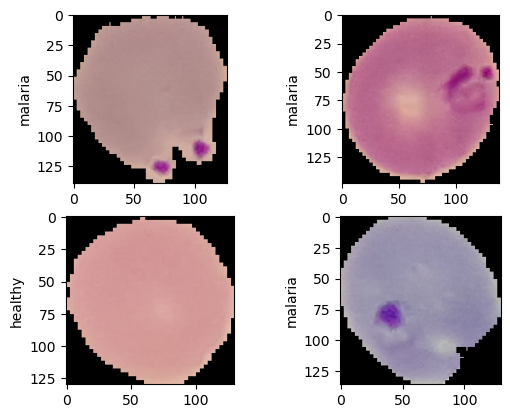

In [8]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

plt.figure(figsize=(15,15))
fig, ax = plt.subplots(nrows=2, ncols=2)

for i in range(2):
    for j in range(2):
        #Reading files after concatenating file name with folder path
        image = imread(os.path.join(base_dir,train_df["filename"][i+2*j]))
        #showing some images of the dataset
        ax[i,j].imshow(image)
        ax[i,j].set_ylabel(train_df["label"][i+2*j])

# 4. Data Preparation

1. since we have textual labels for our images i.e. Parasitized/Uninfected so we will convert them to numerical labels i.e. 0/1

In [9]:
from sklearn import preprocessing

#create the LabelEncoder object
le = preprocessing.LabelEncoder()

# Fit label Encoder
le.fit(train_df['label'])

#transform textual labels
labels = le.transform(train_df['label'])

print('0 - ', le.inverse_transform([0])[0])
print('1 - ', le.inverse_transform([1])[0])

0 -  healthy
1 -  malaria


2. Here we split the dataset into training and validation sets.
Training set is the subset of the dataset that is used for training and validation set is used to evaluate the performance of the model after every epoch.

In [10]:
#import required functions
from sklearn.model_selection import train_test_split

#divide the dataset into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(train_df['filename'],
                                                                    labels, 
                                                                    test_size=0.2, random_state=42,shuffle=True)
#check the shapes of training and validation sets
print(train_files.shape, val_files.shape)
print(train_labels.shape,val_labels.shape)

(15432,) (3858,)
(15432,) (3858,)


In [11]:
from skimage.io import imread, imshow
from skimage.transform import resize

In [12]:
shapes = []
for i in train_df['filename']:
    image = imread(os.path.join(base_dir,i))
    shapes.append(image.shape)

print('Minimum Dimensions - ',np.min(shapes,axis=0))
print('Maximum Dimensions - ',np.max(shapes,axis=0))
print('Average Dimensions - ',np.mean(shapes,axis=0))

Minimum Dimensions -  [40 49  3]
Maximum Dimensions -  [385 364   3]
Average Dimensions -  [132.9600311  132.58335925   3.        ]


We can see that there are images of different shapes. It is recommended to have images in shape size before going ahead with modeling process and it is also dependent on which feature extractor tool, you are using. 

# 5. Method 1: Pixel Values as Features

Here, we will use pixel value as a feature to classify images in Parasitized/Uninfected images. Although, we have looked at that these images are of different shapes so we will bring all the images in same shape by resizing to 40X40. And, after that convert two dimensional matrix to one dimensional vector. So, for each images, we will have 1600 (40X40) features.

In [13]:
IMG_DIMS=(40,40)
train_features_pixel=[]

for i in train_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    features = np.reshape(image,(IMG_DIMS[0]*IMG_DIMS[1]*3))
    train_features_pixel.append(features)

train_features_pixel = np.array(train_features_pixel)

In [14]:
train_features_pixel.shape

(15432, 4800)

In [15]:
IMG_DIMS=(40,40)
val_features_pixel=[]

for i in val_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    features = np.reshape(image,(IMG_DIMS[0]*IMG_DIMS[1]*3))
    val_features_pixel.append(features)

val_features_pixel = np.array(val_features_pixel)

In [16]:
val_features_pixel.shape

(3858, 4800)

# 6. Model1: Model building using Pixel Features

## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#training the Logistic model
clf_lr_pixel = LogisticRegression()
clf_lr_pixel.fit(train_features_pixel,train_labels)

C:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [18]:
preditions_train = clf_lr_pixel.predict(train_features_pixel)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_lr_pixel.predict(val_features_pixel)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  73.05598755832037 %
Validation: Model Accuracy -  68.11819595645412 %


## Linear SVM

In [19]:
from sklearn.svm import LinearSVC

#training the Logistic model
clf_svc_pixel = LinearSVC(random_state=102)
clf_svc_pixel.fit(train_features_pixel,train_labels)

LinearSVC(random_state=102)

In [20]:
preditions_train = clf_svc_pixel.predict(train_features_pixel)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_svc_pixel.predict(val_features_pixel)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  79.52306894764126 %
Validation: Model Accuracy -  67.52203214100571 %


# 7. Method 2: HOG Features

Your image size should be in 64X128(Width X Height) shape to extract HOG features from images. We will first change image shape size to 64X128 first and then extract HOG features.

In [21]:
from skimage.feature import hog

In [30]:
#Showing example of one image first
index = np.random.randint(0, 1000)

image = imread(os.path.join(base_dir, train_files.iloc[index]))
IMG_DIMS = (128, 64)  # SkIMAGE takes input in HEIGHT X WIDTH format
image1 = resize(image, IMG_DIMS)

# calculating HOG features (fixed multichannel issue)
features, hog_image = hog(image1, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, channel_axis=-1)


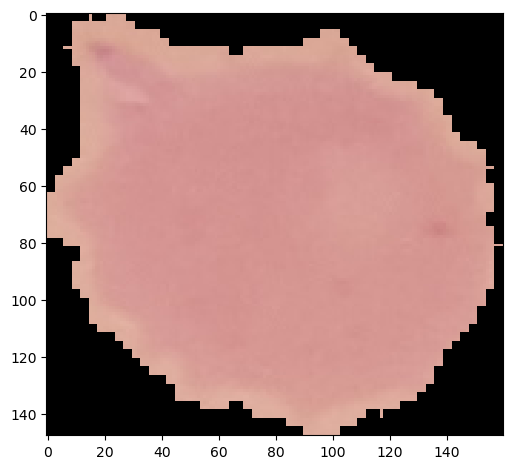

In [31]:
#Original Image
imshow(image)

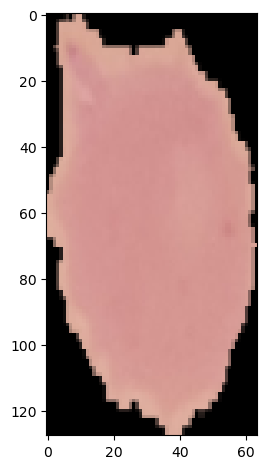

In [32]:
#After Resize
imshow(image1)

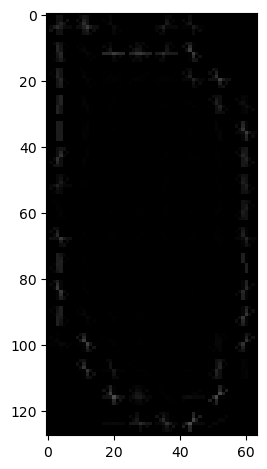

In [33]:
#Image with HOG Image (Look At the Edges)
imshow(hog_image)

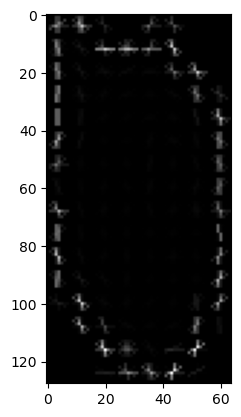

In [34]:
#Highlighting the HOG image using Matplotlib
import matplotlib.pyplot as plt
plt.imshow(hog_image, cmap="gray")

In [28]:
#Shape of HOG Feature Vector
features.shape

(3780,)

## Calculate HOG features for both training and Validation images

In [35]:
IMG_DIMS = (128, 64)

# For Training Images
train_features_hog = []
for i in train_files:
    image = imread(os.path.join(base_dir, i))
    image = resize(image, IMG_DIMS)
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    hog_features = np.reshape(features, (features.shape[0],))
    train_features_hog.append(hog_features)

train_features_hog = np.array(train_features_hog)

# For Validation Images
val_features_hog = []
for i in val_files:
    image = imread(os.path.join(base_dir, i))
    image = resize(image, IMG_DIMS)
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    hog_features = np.reshape(features, (features.shape[0],))
    val_features_hog.append(hog_features)

val_features_hog = np.array(val_features_hog)

# Checking the shape of the final lists after reading all the images
train_features_hog.shape, val_features_hog.shape


((15432, 3780), (3858, 3780))

# 8. Model2: Model building using HOG Features

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#training the Logistic model
clf_lr_hog = LogisticRegression()
clf_lr_hog.fit(train_features_hog,train_labels)

C:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [37]:
preditions_train = clf_lr_hog.predict(train_features_hog)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_lr_hog.predict(val_features_hog)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  88.95800933125972 %
Validation: Model Accuracy -  81.33748055987559 %


## Linear SVM

In [38]:
from sklearn.svm import LinearSVC

#training the Logistic model
clf_svc_hog = LinearSVC()
clf_svc_hog.fit(train_features_hog,train_labels)

LinearSVC()

In [39]:
preditions_train = clf_svc_hog.predict(train_features_hog)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_svc_hog.predict(val_features_hog)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  92.24987039917055 %
Validation: Model Accuracy -  80.35251425609124 %


In [41]:
import joblib

# Save the trained model
model_path = 'malaria_svm_hog_model.joblib'
joblib.dump(clf_svc_hog, model_path)
print(f"Model saved to {model_path}")

# Save the label encoder
le_path = 'label_encoder.joblib'
joblib.dump(le, le_path)
print(f"Label encoder saved to {le_path}")

Model saved to malaria_svm_hog_model.joblib
Label encoder saved to label_encoder.joblib
